In [46]:
import os, sys
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy.stats as stats
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime as dt
import healpy as hp
import astropy as ap
from netCDF4 import Dataset, MFDataset
import h5py
import xarray as xr
from mpl_toolkits.mplot3d import axes3d
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors
import cftime
import matplotlib.lines as mlines
from sklearn.decomposition import PCA
from sklearn import preprocessing, cluster
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
import csv
from itertools import product
from sklearn.ensemble import RandomForestRegressor
import matplotlib.patches as patches
import statsmodels.api as sm
import pymannkendall as mk

<b>Finding EOF Modes of DJF SST Anomalies</b>

Alex Chang

AOS 219

We first find the non-rotated EOF's of the DJF SST Anomalies. The output is shown below:

In [1]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

import numpy as np
import scipy
import scipy.io
from eofs.standard import Eof
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeat
# from eofs_func import Detrend
from regressionutils import Detrend

# directory
ddir = '/home/achang1029/Misc Files/'

#------------------------------------------------------------------------------
# read in sst data
lats = Dataset('sst.mnmean.v4.nc')['lat'][:]
lons = Dataset('sst.mnmean.v4.nc')['lon'][:]
ssta = Dataset('sst.mnmean.v4.nc')['sst'][:]

# years
yrs = np.arange(1854,2019.33,1/12)

# detrend 
ssta_dt = np.empty(ssta.shape)
for yy in range(len(lats)):
    for xx in range(len(lons)):
        ssta_dt[:,yy,xx] = Detrend(yrs, ssta[:,yy,xx])

# mask
ssta_dt = np.ma.masked_invalid(ssta_dt)

# normalize
ssta_dt = (ssta_dt - ssta_dt.mean(axis =0))/ssta_dt.std(axis =0)

#------------------------------------------------------------------------------
# apply EOF
wgts   = np.cos(np.deg2rad(lats))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(ssta_dt, weights=wgts)

eofs = solver.eofs(neofs=3)
pcs  = solver.pcs(npcs=3, pcscaling=1)  
vfrc = solver.varianceFraction()
        
#------------------------------------------------------------------------------
# plot
sns.set(style='ticks', context='paper')

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.04; uu = 0.04
clev = np.linspace(ll,uu,9)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofs[0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('EOF1 ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs,pcs[:, 0], color='#377eb8', linewidth=1)
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-3,3)
ax2.set_xlabel('Year')

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofs[1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('EOF2 ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs,pcs[:, 1], color='#377eb8', linewidth=1)
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-3,3)
ax4.set_xlabel('Year')

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofs[2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('EOF3 ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs,pcs[:, 2], color='#377eb8', linewidth=1)
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-3,3)
ax6.set_xlabel('Year')
plt.show()

fig1 = plt.figure(figsize=(10, 5))
axs = fig1.add_subplot(111)
eof_num = np.arange(1,vfrc.shape[0]+1)
axs.plot(eof_num, vfrc*100, linewidth=2,color='k')
axs.plot(eof_num, vfrc*100, linestyle='None', marker="o", color='#3182bd', markersize=6)
axs.set_title('Fraction of the total variance represented by each EOF', fontsize=14)
axs.set_xlabel('EOF')
axs.set_ylabel('Variance Fraction %')
axs.set_xlim(0, 100)
axs.set_xticks(range(0, 100, 10))
axs.set_xticklabels(np.arange(0, 100, 10).astype('int').astype('str'))
plt.show()



ModuleNotFoundError: No module named 'numpy'

The above output shows that the first EOF explains about 67% of the SST variance, while the second EOF explains only about 9% of the SST variance. Looking at the EOF's and the principal components, the first EOF mode is likely the seasonal changes in SST within each year since the positive anomalies are all in the northern hemisphere, while the negative anomalies are all within the southern hemisphere. Additionally, the principal component shows a seasonal cycle. The second EOF mode is likely the Pacific Decadal Oscillation (PDO) since there are positive anomalies in the equatorial/eastern Pacific and negative anomalies in the western and subtropical Pacific. The principal component shows some decadal variation, further supporting this.

We now apply the same thing, but for the rotated EOF's. The output is shown below:

/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/dat

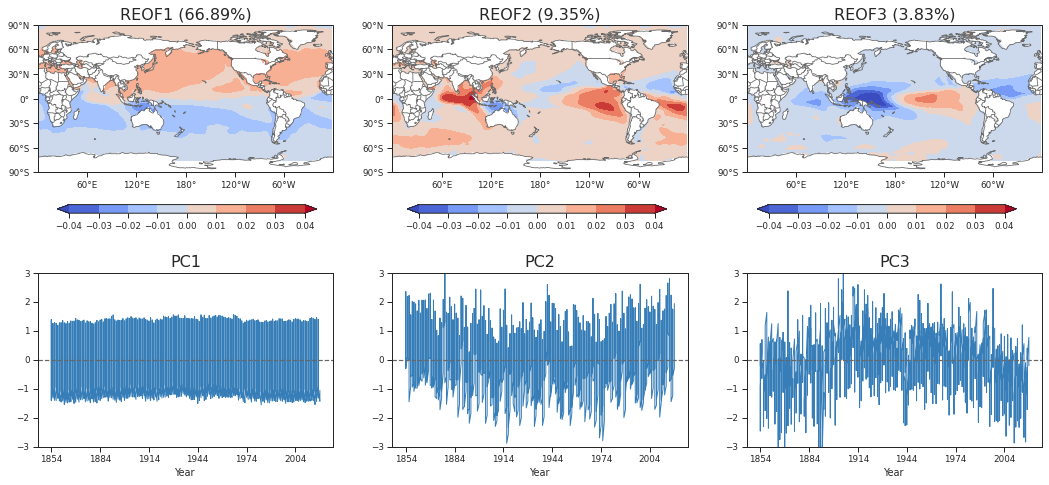

In [57]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

import numpy as np
import scipy
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeat
from eofs.standard import Eof
# from eofs_func import Detrend
from regressionutils import Detrend

# directory
ddir = '/home/achang1029/Misc Files/'

#------------------------------------------------------------------------------
# read in sst data
lats = Dataset('sst.mnmean.v4.nc')['lat'][:]
lons = Dataset('sst.mnmean.v4.nc')['lon'][:]
ssta1 = Dataset('sst.mnmean.v4.nc')['sst'][:]


# years
yrs = np.arange(1854,2019.33,1/12).astype('int')

# detrend 
ssta_dt = np.empty(ssta.shape)
for yy in range(len(lats)):
    for xx in range(len(lons)):
        ssta_dt[:,yy,xx] = Detrend(yrs, ssta[:,yy,xx])

# mask
ssta_dt = np.ma.masked_invalid(ssta_dt)

# normalize
ssta_dt = (ssta_dt - ssta_dt.mean(axis =0))/ssta_dt.std(axis =0)

#------------------------------------------------------------------------------
# apply EOF
wgts   = np.cos(np.deg2rad(lats))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(ssta_dt, weights=wgts)

eofs = solver.eofs(neofs=5)
pcs  = solver.pcs(npcs=5, pcscaling=1)  
vfrc = solver.varianceFraction(neigs=5)

# the first 5 eofs are selected to do varimax rotation

def varimax_rotation(x, eps=1e-10, itermax=100):
    """
    Rotate EOFs according to varimax algorithm

    Variables:
    x :: a matrix of EOFs (one column for each EOF)
    R :: rotation matrix
    y :: new EOFs (new_EOFs =EOFs*R)
    
    """
    nrow, ncol = x.shape
    R = np.eye(ncol)
    var = 0

    for ii in range(itermax):
        x_rot = np.dot(x, R)
        tmp = np.diag(np.sum(x_rot ** 2, axis=0)) / nrow 
        u, s, v = np.linalg.svd(np.dot(x.T, x_rot ** 3 - np.dot(x_rot, tmp)))
        R = np.dot(u, v)
        var_new = np.sum(s)
        if var_new < var * (1 + eps):
            print ("varimax done in ", ii , " iteration")
            break
        var = var_new
        
    y = np.dot(x,R)

    return y,R

# preprocess SSTA
nb, nlat_sst, nlon_sst = eofs.shape
eofs2d = np.reshape(eofs, (nb, nlat_sst*nlon_sst), order='F')
eofs2dt = np.transpose(eofs2d, (1, 0))

nonMissingIndex = np.where(np.isnan(eofs2dt[:,0]) == False)[0]
eofs2dtNoMissing = eofs2dt[nonMissingIndex,: ]

# apply varimax rotation
eofs_r,matrix_r = varimax_rotation(eofs2dtNoMissing)

# reshape rotated EOFs
eofs_rtr = np.ones([nlat_sst*nlon_sst,nb]) * np.NaN
eofs_rtr = eofs_rtr.astype(eofs_r.dtype)
eofs_rtr[nonMissingIndex,:] = eofs_r[:,:]
eofs_rtr = eofs_rtr.reshape([nlat_sst,nlon_sst,nb], order='F')

#------------------------------------------------------------------------------
# plot
sns.set(style='ticks', context='paper')

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.04; uu = 0.04
clev = np.linspace(ll,uu,9)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofs_rtr[:,:,0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('REOF1 ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
# ax1.set_title('REOF1', fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs,pcs[:, 0], color='#377eb8', linewidth=1)
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-3,3)
ax2.set_xlabel('Year')

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofs_rtr[:,:,1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('REOF2 ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
# ax3.set_title('REOF2', fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs,pcs[:, 1], color='#377eb8', linewidth=1)
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-3,3)
ax4.set_xlabel('Year')

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofs_rtr[:,:,2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('REOF3 ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
# ax5.set_title('REOF3', fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs,pcs[:, 2], color='#377eb8', linewidth=1)
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-3,3)
ax6.set_xlabel('Year')

plt.show()


About 67% of the variance is explained by EOF 1, while 9% of the variance is explained by EOF 2. This is similar to the results seen in the non-rotated EOF's for the first EOF. The second EOF shows somewhat different patterns spatially, however. It is more likely ENSO rather than the PDO because the strongest anomalies are confined to to the eastern portion of the Equatorial Pacific. Additionally, the second principal component shows greater variability at a yearly timescale rather than multidecadal.

Now we apply the same thing, but for Complex EOF's. The output is shown below:

/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/dat

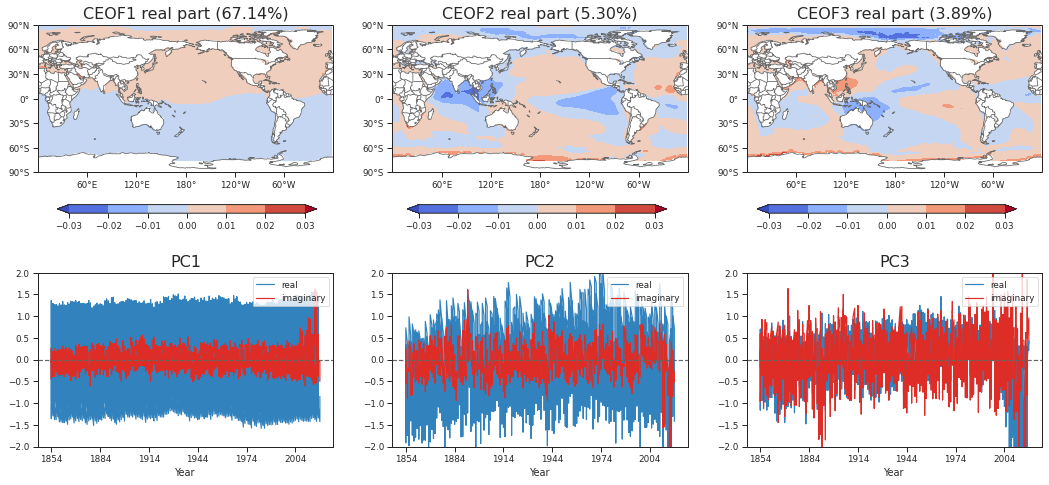

/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  line_strings = list(multi_line_string)
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/cartopy/crs.py:256: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  line_strings = li

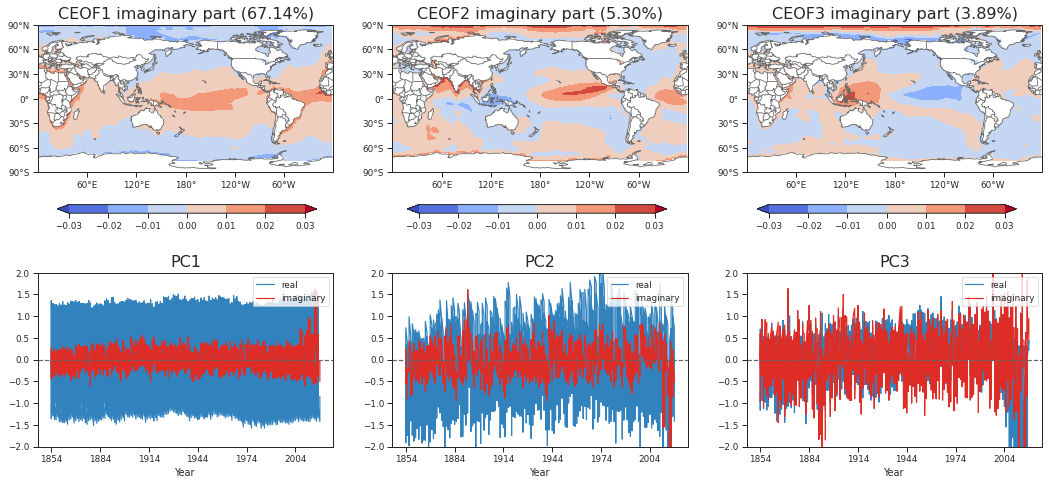

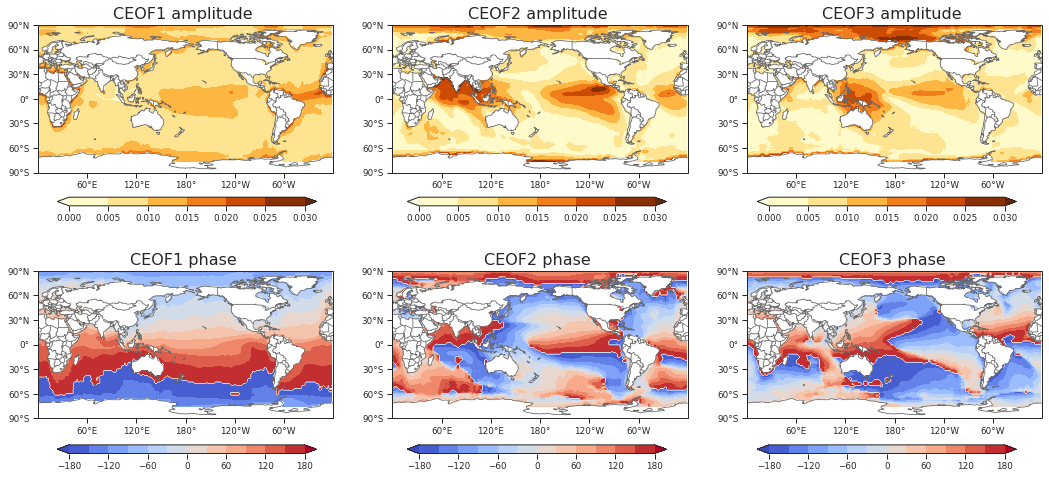

/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/data/rong3/achang1029/anaconda3/envs/healpix/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


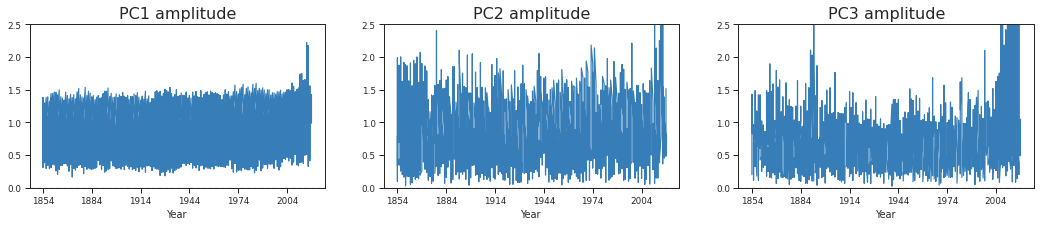

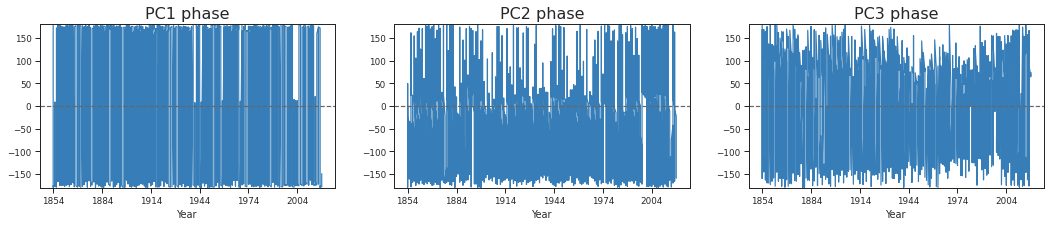

In [58]:
#!/usr/bin/env python2
# -*- coding: utf-8 -*-

import numpy as np
import scipy
import scipy.io
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeat
from eofs.standard import Eof
from scipy.signal import hilbert
import math
# from eofs_func import Detrend
from regressionutils import Detrend

# directory
ddir = '/home/achang1029/Misc Files/'

#------------------------------------------------------------------------------
# read in sst data
lats = Dataset('sst.mnmean.v4.nc')['lat'][:]
lons = Dataset('sst.mnmean.v4.nc')['lon'][:]
ssta1 = Dataset('sst.mnmean.v4.nc')['sst'][:]

# years
yrs = np.arange(1854,2019.33,1/12).astype('int')

# detrend 
ssta_dt = np.empty(ssta.shape)
for yy in range(len(lats)):
    for xx in range(len(lons)):
        ssta_dt[:,yy,xx] = Detrend(yrs, ssta[:,yy,xx])

# mask
ssta_dt = np.ma.masked_invalid(ssta_dt)

# normalize
ssta_dt = (ssta_dt - ssta_dt.mean(axis =0))/ssta_dt.std(axis =0)

# proprocess SST
ntime, nlat_sst, nlon_sst = ssta_dt.shape
sst2d = np.reshape(ssta_dt, (ntime, nlat_sst*nlon_sst), order='F')

nonMissingIndex = np.where(np.isnan(sst2d[0]) == False)[0]
sst2dNoMissing = sst2d[:, nonMissingIndex]

# hilbert transform
sst2dh = hilbert(sst2dNoMissing)
#sst_real = np.real(hilbert(sst2dNoMissing))
#sst_img = np.imag(hilbert(sst2dNoMissing))

#------------------------------------------------------------------------------
# apply EOF
wgts   = np.cos(np.deg2rad(lats))
wgts   = wgts.reshape(len(wgts), 1)
solver = Eof(sst2dh, weights=wgts)

eofs = solver.eofs(neofs=3)
#eofs = solver.eofsAsCovariance(neofs=3)
pcs  = solver.pcs(npcs=3, pcscaling=1)  
vfrc = solver.varianceFraction(neigs=3)

# eofs
eofs_real = np.real(eofs)
eofs_imag = np.imag(eofs)

# pcs
pcs_r = np.real(pcs)
pcs_i = np.imag(pcs)

# spatial amplitude
eofs_am = np.power(eofs*np.conjugate(eofs), 0.5)
eofs_am = np.real(eofs_am)
# spatial phase
eofs_ph = np.arctan2(eofs_imag,eofs_real)
eofs_ph = eofs_ph*180./math.pi
# temporal amplitude
Rt = np.power(pcs*np.conjugate(pcs), 0.5)
# temporal phase
pht = np.arctan2(pcs_i,pcs_r)
pht = pht*180./math.pi

# reshape real and imaginary part of eof, amplitude and phase
eofsn_r = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofsn_r = eofsn_r.astype(eofs_real.dtype)

eofsn_i = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofsn_i = eofsn_i.astype(eofs_imag.dtype)

eofs_amr = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofs_amr = eofs_amr.astype(eofs_am.dtype)

eofs_phr = np.ones([3,nlat_sst*nlon_sst]) * np.nan
eofs_phr = eofs_phr.astype(eofs_ph.dtype)

for ii in range(3):
    eofsn_r[ii,nonMissingIndex] = eofs_real[ii,:]
    eofsn_i[ii,nonMissingIndex] = eofs_imag[ii,:]
    eofs_amr[ii,nonMissingIndex] = eofs_am[ii,:]
    eofs_phr[ii,nonMissingIndex] = eofs_ph[ii,:]
    
eofsn_r = eofsn_r.reshape([3,nlat_sst,nlon_sst], order='F')
eofsn_i = eofsn_i.reshape([3,nlat_sst,nlon_sst], order='F')
eofs_amr = eofs_amr.reshape([3,nlat_sst,nlon_sst], order='F')
eofs_phr = eofs_phr.reshape([3,nlat_sst,nlon_sst], order='F')

#------------------------------------------------------------------------------
# plot parameter
sns.set(style='ticks', context='paper')


#------------------------------------------------------------------------------
# plot real part and PCs
# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.03; uu = 0.03
clev = np.linspace(ll,uu,7)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofsn_r[0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('CEOF1 real part ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofsn_r[1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('CEOF2 real part ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')

cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofsn_r[2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('CEOF3 real part ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs, pcs_r[:,0], color = '#3182bd', label='real')
ax2.plot(yrs, pcs_i[:,0], color = '#de2d26', label='imaginary')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-2,2)
ax2.set_xlabel('Year')
ax2.legend(fancybox=True,loc=1)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs, pcs_r[:,1], color = '#3182bd', label='real')
ax4.plot(yrs, pcs_i[:,1], color = '#de2d26', label='imaginary')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-2,2)
ax4.set_xlabel('Year')
ax4.legend(fancybox=True,loc=1)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs, pcs_r[:,2], color = '#3182bd', label='real')
ax6.plot(yrs, pcs_i[:,2], color = '#de2d26', label='imaginary')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-2,2)
ax6.set_xlabel('Year')
ax6.legend(fancybox=True,loc=1)

plt.show()

#------------------------------------------------------------------------------
## plot imaginary part and PCs

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = -0.03; uu = 0.03
clev = np.linspace(ll,uu,7)

# EOF1
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofsn_i[0], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('CEOF1 imaginary part ({0:0.2f}%)'.format(100*vfrc[0]), fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# EOF2
ax3 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofsn_i[1], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('CEOF2 imaginary part ({0:0.2f}%)'.format(100*vfrc[1]), fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')

cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb1 = fig.colorbar(cs3, cax=cax2, orientation='horizontal')
cb1.outline.set_visible(True)

# EOF3
ax5 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofsn_i[2], clev, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('CEOF3 imaginary part ({0:0.2f}%)'.format(100*vfrc[2]), fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs5, cax=cax3, orientation='horizontal')
cb2.outline.set_visible(True)

# PC1               
ax2 = fig.add_subplot(234)
ax2.plot(yrs, pcs_r[:,0], color = '#3182bd', label='real')
ax2.plot(yrs, pcs_i[:,0], color = '#de2d26', label='imaginary')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-2,2)
ax2.set_xlabel('Year')
ax2.legend(fancybox=True,loc=1)

# PC2 
ax4 = fig.add_subplot(235)
ax4.plot(yrs, pcs_r[:,1], color = '#3182bd', label='real')
ax4.plot(yrs, pcs_i[:,1], color = '#de2d26', label='imaginary')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-2,2)
ax4.set_xlabel('Year')
ax4.legend(fancybox=True,loc=1)

# PC3 
ax6 = fig.add_subplot(236)
ax6.plot(yrs, pcs_r[:,2], color = '#3182bd', label='real')
ax6.plot(yrs, pcs_i[:,2], color = '#de2d26', label='imaginary')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-2,2)
ax6.set_xlabel('Year')
ax6.legend(fancybox=True,loc=1)

plt.show()


#------------------------------------------------------------------------------
## plot spatial amplitude and phase

# MAPS
fig = plt.figure(figsize=(18, 8))
fig.subplots_adjust(wspace=0.2, hspace=0.3)
# the amount of width and height reserved for blank space between subplots

# formatting for tick marks
xfr = LongitudeFormatter(zero_direction_label=True)
yfr = LatitudeFormatter()

# contour levels
ll = 0.; uu = 0.03
clev = np.linspace(ll,uu,7)
clev2 = np.linspace(-180,180,13)

# EOF1 amplitude
ax1 = fig.add_subplot(231, projection=ccrs.PlateCarree(central_longitude=180))
cs1 = ax1.contourf(lons,lats, eofs_amr[0], clev, cmap=plt.cm.YlOrBr, extend='both', transform=ccrs.PlateCarree())
ax1.set_title('CEOF1 amplitude ', fontsize=16)
ax1.set_extent([-180, 180, -90, 90])
ax1.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax1.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax1.xaxis.set_major_formatter(xfr)
ax1.yaxis.set_major_formatter(yfr)
ax1.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax1.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax1 = fig.add_axes([0.14, 0.53, 0.2, 0.015])
cb0 = fig.colorbar(cs1, cax=cax1, orientation='horizontal')
cb0.outline.set_visible(True)

# EOF2 amplitude
ax2 = fig.add_subplot(232, projection=ccrs.PlateCarree(central_longitude=180))
cs2 = ax2.contourf(lons,lats, eofs_amr[1], clev, cmap=plt.cm.YlOrBr, extend='both', transform=ccrs.PlateCarree())
ax2.set_title('CEOF2 amplitude ', fontsize=16)
ax2.set_extent([-180, 180, -90, 90])
ax2.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax2.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax2.xaxis.set_major_formatter(xfr)
ax2.yaxis.set_major_formatter(yfr)
ax2.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax2.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax2 = fig.add_axes([0.41, 0.53, 0.2, 0.015])
cb2 = fig.colorbar(cs2, cax=cax2, orientation='horizontal')
cb2.outline.set_visible(True)

# EOF3 amplitude
ax3 = fig.add_subplot(233, projection=ccrs.PlateCarree(central_longitude=180))
cs3 = ax3.contourf(lons,lats, eofs_amr[2], clev, cmap=plt.cm.YlOrBr, extend='both', transform=ccrs.PlateCarree())
ax3.set_title('CEOF3 amplitude ', fontsize=16)
ax3.set_extent([-180, 180, -90, 90])
ax3.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax3.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax3.xaxis.set_major_formatter(xfr)
ax3.yaxis.set_major_formatter(yfr)
ax3.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax3.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax3 = fig.add_axes([0.68, 0.53, 0.2, 0.015])
cb3 = fig.colorbar(cs3, cax=cax3, orientation='horizontal')
cb3.outline.set_visible(True)

# EOF1 phase
ax4 = fig.add_subplot(234, projection=ccrs.PlateCarree(central_longitude=180))
cs4 = ax4.contourf(lons,lats, eofs_phr[0], clev2, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax4.set_title('CEOF1 phase ', fontsize=16)
ax4.set_extent([-180, 180, -90, 90])
ax4.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax4.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax4.xaxis.set_major_formatter(xfr)
ax4.yaxis.set_major_formatter(yfr)
ax4.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax4.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax4 = fig.add_axes([0.14, 0.1, 0.2, 0.015])
cb4 = fig.colorbar(cs4, cax=cax4, orientation='horizontal')
cb4.outline.set_visible(True)


# EOF2 phase
ax5 = fig.add_subplot(235, projection=ccrs.PlateCarree(central_longitude=180))
cs5 = ax5.contourf(lons,lats, eofs_phr[1], clev2, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax5.set_title('CEOF2 phase ', fontsize=16)
ax5.set_extent([-180, 180, -90, 90])
ax5.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax5.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax5.xaxis.set_major_formatter(xfr)
ax5.yaxis.set_major_formatter(yfr)
ax5.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax5.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax5 = fig.add_axes([0.41, 0.1, 0.2, 0.015])
cb5 = fig.colorbar(cs5, cax=cax5, orientation='horizontal')
cb5.outline.set_visible(True)

# EOF3 phase
ax6 = fig.add_subplot(236, projection=ccrs.PlateCarree(central_longitude=180))
cs6 = ax6.contourf(lons,lats, eofs_phr[2], clev2, cmap=plt.cm.coolwarm, extend='both', transform=ccrs.PlateCarree())
ax6.set_title('CEOF3 phase ', fontsize=16)
ax6.set_extent([-180, 180, -90, 90])
ax6.set_xticks(range(60, 301, 60), crs=ccrs.PlateCarree())
ax6.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())
ax6.xaxis.set_major_formatter(xfr)
ax6.yaxis.set_major_formatter(yfr)
ax6.add_feature(cfeat.COASTLINE, edgecolor='#686868')
ax6.add_feature(cfeat.BORDERS, edgecolor='#686868')
                
cax6 = fig.add_axes([0.68, 0.1, 0.2, 0.015])
cb6 = fig.colorbar(cs6, cax=cax6, orientation='horizontal')
cb6.outline.set_visible(True)

plt.show()

#------------------------------------------------------------------------------
# plot temporal pcs

# MAPS
fig = plt.figure(figsize=(18, 3))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# PC1               
ax2 = fig.add_subplot(131)
ax2.plot(yrs, Rt[:,0], color = '#377eb8')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1 amplitude', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(0,2.5)
ax2.set_xlabel('Year')

# PC2 
ax4 = fig.add_subplot(132)
ax4.plot(yrs, Rt[:,1], color = '#377eb8')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2 amplitude', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(0,2.5)
ax4.set_xlabel('Year')

# PC3 
ax6 = fig.add_subplot(133)
ax6.plot(yrs, Rt[:,2], color = '#377eb8')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3 amplitude', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(0,2.5)
ax6.set_xlabel('Year')

plt.show()


#------------------------------------------------------------------------------
# plot temporal phase

# MAPS
fig = plt.figure(figsize=(18, 3))
fig.subplots_adjust(wspace=0.2, hspace=0.5)
# the amount of width and height reserved for blank space between subplots

# PC1               
ax2 = fig.add_subplot(131)
ax2.plot(yrs, pht[:,0], color = '#377eb8')
ax2.axhline(0, linestyle='--', color='#666666')
ax2.set_title('PC1 phase', fontsize=16)
ax2.set_xticks(range(1854,2019,30))
ax2.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax2.set_ylim(-180,180)
ax2.set_xlabel('Year')

# PC2 
ax4 = fig.add_subplot(132)
ax4.plot(yrs, pht[:,1], color = '#377eb8')
ax4.axhline(0, linestyle='--', color='#666666')
ax4.set_title('PC2 phase', fontsize=16)
ax4.set_xticks(range(1854,2019,30))
ax4.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax4.set_ylim(-180,180)
ax4.set_xlabel('Year')

# PC3 
ax6 = fig.add_subplot(133)
ax6.plot(yrs, pht[:,2], color = '#377eb8')
ax6.axhline(0, linestyle='--', color='#666666')
ax6.set_title('PC3 phase', fontsize=16)
ax6.set_xticks(range(1854,2019,30))
ax6.set_xticklabels(np.arange(1854,2019,30).astype('int').astype('str'))
ax6.set_ylim(-180,180)
ax6.set_xlabel('Year')

plt.show()


The real part of the first EOF is likely the same as in the above two cases: the seasonal SST variation. The imaginary part of the first EOF is likely the SST gradient between the tropics and the poles. The real part of the second EOF is likely the PDO given the broader negative anomalies in the equatorial Pacific and positive anomalies in the western and subtropical Pacific. The imaginary part of the second EOF is likely ENSO given the much more localized positive anomalies in the equatorial Pacific.